### stint data analysis

visualize to separate types of pitstops

<normal/green, caution/yellow, short pit stops>


base: 22./stage_model_regressor

predicting target: end_rank = start_rank + change(old target)
prediction models of chg_of_rank_in_stage on stage dataset

data format:
    target , eventid ,    car_number,    stageid,     features...

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math


In [2]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import xgboost as xgb


In [3]:
# bulid regression model
#classifiers = ['currank','avgrank','dice','lr','lrl1','lsvc','lsvcl2','rf','lrbias','xgb']
classifiers = ['currank','avgrank','dice','lr','lsvc','lsvcl2','rf','lrbias','xgb']
train_x, train_y, test_x, test_y = None, None, None, None
train_df, test_df = None, None

def get_classifier(classifier = 'lr'):
    
    class_weight = None
    
    if classifier == "lsvc":
        clf = LinearSVC(penalty='l1',dual=False, tol=1e-3, class_weight=class_weight )
    elif classifier == "lsvcl2":
        clf = LinearSVC(penalty='l2', tol=1e-4, class_weight=class_weight)
    elif classifier == 'rf':
        #clf = RandomForestClassifier(n_estimators=100, n_jobs=4,criterion='entropy', min_samples_split=1,class_weight = class_weight)
        clf = RandomForestClassifier(n_estimators=100, n_jobs=-1,criterion='entropy', class_weight = class_weight)
    elif classifier == 'lr':
        clf = LogisticRegression(class_weight = class_weight, n_jobs=-1, fit_intercept = False, verbose = 0)
    elif classifier == 'lrbias':
        clf = LogisticRegression(class_weight = class_weight, n_jobs=-1, fit_intercept = True, verbose = 1)
    elif classifier == 'lrl1':
        clf = LogisticRegression(class_weight = class_weight, penalty='l1',n_jobs=-1)
    elif classifier == 'xgb':
        clf = xgb.XGBClassifier(booster = 'gbtree', nthread = -1, subsample = 1, 
                                n_estimators = 600, colsample_bytree = 1, max_depth = 6, min_child_weight = 1)
    elif classifier == 'dice':
        clf = RandomDice('1234')
    elif classifier == 'currank':
        clf = CurRank()
    elif classifier == 'avgrank':
        clf = AverageRank()        
    else:
        clf = None
        
    return clf


class CurRank():
    """
    predict with current rank
    """
    def __init__(self):
        pass
    def fit(self, x, y):
        pass
    def predict(self, test_x):
        pred_y = [0 for x in range(test_x.shape[0])]
        return np.array(pred_y)
    
class AverageRank():
    """
    print('[*] predict with average rankchg (change_in_rank_all):idx = 15')
    change_in_rank_all = test[:,15]
    pred_y_avg = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in change_in_rank_all])
    """
    def __init__(self):
        pass
    def fit(self, x, y):
        pass
    def predict(self, test_x):
        pred_y = []
        for x in test_x:
            #13, change_in_rank_all
            pred_y.append(x[13])
        pred_y_avg = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in pred_y])
        return np.array(pred_y_avg)   

class RandomDice():
    """
    a random dice model
    """
    def __init__(self, seed='1234'):
        self.dist = []
        self.val = []
        random.seed(seed)
    
    def fit(self, x, y):
        total = y.shape[0]
        yval = set(y)
        
        ratio = 0.
        for val in yval:
            self.val.append(val)
            ratio += np.sum(y==val)*1.0 / total
            self.dist.append(ratio)
            
    def predict(self, test_x):
        pred_y = []
        for x in test_x:
            dice = random.random()
            #search in self.dist
            find_idx = -1
            for idx, ratio in enumerate(self.dist):
                if dice <= ratio:
                    find_idx = idx
                    break
            
            #or the last one match
            pred_y.append(self.val[find_idx])
            
        return np.array(pred_y)

def evaluate(test_y, pred_y):
    precision = metrics.precision_score(test_y, pred_y, average=None) 
    recall = metrics.recall_score(test_y, pred_y, average=None)
    f1 = metrics.f1_score(test_y, pred_y, average=None)
    accuracy = metrics.accuracy_score(test_y, pred_y)
    print('precision=%s, recall=%s, f1=%s, accuracy=%.2f'%(precision,recall, f1, accuracy))
    return accuracy
    
#
#features
#    cols=[Myidx, 'target','eventid','car_number','stageid',
#             'firststage','pit_in_caution','start_position',
#             'start_rank','start_rank_ratio','top_pack','bottom_pack',
#             'average_rank','average_rank_all',
#             'change_in_rank','change_in_rank_all','rate_of_change','rate_of_change_all']    
def split_by_eventid(stagedata, eventid):
    """
    split by eventid
    """
    #if not eventid in stagedata:
    #    print('error, %d not found in stagedata'%eventid)
    #    return
    
    train_df= stagedata[stagedata['eventid'] != eventid]
    test_df = stagedata[stagedata['eventid'] == eventid]
    
    train = stagedata[stagedata['eventid'] != eventid].to_numpy()
    test  = stagedata[stagedata['eventid'] == eventid].to_numpy()

    #2:car_number
    train_x = train[:,2:]
    train_y = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in train[:,1]])
    test_x = test[:,2:]
    test_y = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in test[:,1]])
    
    return train_df, test_df, train_x, train_y, test_x, test_y


def split_by_stageid(stagedata, stageid):
    """
    split by stageid
    """
    #if not eventid in stagedata:
    #    print('error, %d not found in stagedata'%eventid)
    #    return
    
    train = stagedata[stagedata['stageid'] <= stageid].to_numpy()
    test  = stagedata[stagedata['stageid'] > stageid].to_numpy()

    train_x = train[:,2:]
    train_y = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in train[:,1]])
    test_x = test[:,2:]
    test_y = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in test[:,1]])
    
    return train, test, train_x, train_y, test_x, test_y


### baseline
def baseline_model():
    #1. predict with current rank, rankchg = 0
    print('[*] predict with current rank, rankchg = 0')
    pred_y_simple = np.zeros_like(test_y)
    score1 = evaluate(test_y, pred_y_simple)

    #2. predict with average rankchg (change_in_rank_all):idx = 15
    print('[*] predict with average rankchg (change_in_rank_all):idx = 15')
    change_in_rank_all = test[:,15]
    pred_y_avg = np.array([1 if x > 0 else (-1 if x < 0 else 0) for x in change_in_rank_all])
    score2 = evaluate(test_y, pred_y_avg)
    return score1, score2

def classifier_model(name='lr'):
    ### test learning models
    print('[*] predict with %s model'%name)
    clf = get_classifier(name)
    clf.fit(train_x, train_y)

    pred_y = clf.predict(test_x)
    score = evaluate(test_y, pred_y)
    return score

In [4]:
def build_df(testdf, pred_y):
    """
    build a standard stint prediction result:
    carno	startlap	startrank	endrank	diff	sign	pred_endrank	pred_diff	pred_sign
    endlap pred_endlap
    """
    
    print('build_df: len testdf=%d, len of pred_y=%d'%(len(testdf), len(pred_y)))
    
    test = testdf[['car_number','start_lap','start_rank','target']].values
    test[:,1] = test[:,1]-1
    test[:,2] = test[:,2]-1
    test[:,3] = test[:,2] + test[:,3]
    dfout = pd.DataFrame(test, columns =['carno','startlap', 'startrank','endrank'])
    
    dfout['diff'] = dfout['endrank'] - dfout['startrank']
    signVec = dfout['diff'].values.copy()
    for idx in range(len(signVec)):
        sign = 0
        if signVec[idx] > 0:
            sign = 1
        elif signVec[idx] < 0:
            sign = -1
        signVec[idx] = sign
    dfout['sign'] = signVec

    # add predictions
    dfout['pred_endrank'] = pred_y +  dfout['startrank']
    dfout['pred_diff'] = pred_y 
    signVec = dfout['pred_diff'].values.copy()
    for idx in range(len(signVec)):
        sign = 0
        if signVec[idx] > 0:
            sign = 1
        elif signVec[idx] < 0:
            sign = -1
        signVec[idx] = sign
    dfout['pred_sign'] = signVec
    return dfout
    

def test_20182019():
    global train_x, train_y, test_x, test_y,train_df, test_df 
    
    ### fix train
    cols = ['runid','trainsize','testsize','testdistribution']
    cols.extend(classifiers)
    print('cols:%s'%cols)
    retdf = pd.DataFrame([],columns=cols)


    events = set(stagedata['eventid'])

    years = ['2013','2014','2015','2016','2017','2018','2019']
    #events = ['Indy500']
    eventsname = [f'Indy500-{x}' for x in years]
    events_id={key:idx for idx, key in enumerate(eventsname)}

    #first 
    eventid = events_id['Indy500-2018']
    ignore_eventid = events_id['Indy500-2019']
    stdata_2018 = stagedata[stagedata['eventid']!=ignore_eventid]

    print('Testset = %s'%eventsname[eventid])

    train, test, train_x, train_y, test_x, test_y = split_by_eventid(stdata_2018, eventid)
    test_distribution = '+:%d,0:%d,-:%d'%(np.sum(test_y>0),np.sum(test_y==0),np.sum(test_y<0))
    #print('Testset by stageid= %s, trainsize=%d, testsize=%d, dist=%s'%
    #      (stageid, train_x.shape[0], test_x.shape[0], test_distribution))

    #record
    rec = [eventsname[eventid],train_x.shape[0],test_x.shape[0],test_distribution]

    acc = [0 for x in range(len(classifiers))]
    for idx, clf in enumerate(classifiers):
        acc[idx] = classifier_model(clf)

    rec.extend(acc)
    print('rec:%s'%rec)

    #new df
    df = pd.DataFrame([rec],columns=cols)
    retdf = pd.concat([retdf, df])        


    eventid = events_id['Indy500-2019']
    ignore_eventid = events_id['Indy500-2018']
    stdata_2019 = stagedata[stagedata['eventid']!=ignore_eventid]

    print('Testset = %s'%eventsname[eventid])

    train2, test2, train_x2, train_y2, test_x, test_y = split_by_eventid(stdata_2019, eventid)
    test_distribution = '+:%d,0:%d,-:%d'%(np.sum(test_y>0),np.sum(test_y==0),np.sum(test_y<0))

    #record
    rec = [eventsname[eventid],train_x.shape[0],test_x.shape[0],test_distribution]

    acc = [0 for x in range(len(classifiers))]
    for idx, clf in enumerate(classifiers):
        acc[idx] = classifier_model(clf)

    rec.extend(acc)
    print('rec:%s'%rec)

    #new df
    df = pd.DataFrame([rec],columns=cols)
    retdf = pd.concat([retdf, df]) 
    
    retdf.to_csv(f'stint_classifier_result_{suffix}.csv', float_format='%.3f')
    return retdf

def test_feature_importance(clf, event='2018', ignore='2019'):
    global train_x, train_y, test_x, test_y,train_df, test_df 
    
    ### fix train
    cols = ['runid','trainsize','testsize','testdistribution']
    cols.extend(classifiers)
    print('cols:%s'%cols)
    retdf = pd.DataFrame([],columns=cols)


    events = set(stagedata['eventid'])

    years = ['2013','2014','2015','2016','2017','2018','2019']
    #events = ['Indy500']
    eventsname = [f'Indy500-{x}' for x in years]
    events_id={key:idx for idx, key in enumerate(eventsname)}

    #first 
    eventid = events_id[f'Indy500-{event}']
    ignore_eventid = events_id[f'Indy500-{ignore}']
    stdata_2018 = stagedata[stagedata['eventid']!=ignore_eventid]

    print('Testset = %s'%eventsname[eventid])

    train_df, test_df , _train_x, train_y, _test_x, test_y = split_by_eventid(stdata_2018, eventid)
    test_distribution = '+:%d,0:%d,-:%d'%(np.sum(test_y>0),np.sum(test_y==0),np.sum(test_y<0))
    print('Testset trainsize=%s, testsize=%s, dist=%s'%
          (_train_x.shape, _test_x.shape, test_distribution))

    #record
    featureCnt = _train_x.shape[1]
    acc = np.zeros((featureCnt))
    for fid in range(featureCnt):
        sel = list(range(0,featureCnt,1))
        
        sel.remove(fid)
        
        train_x = _train_x[:, sel]
        test_x = _test_x[:, sel]
        
        print('sel:', sel)
        print('train_x shape:', train_x.shape)
        
        acc[fid] = classifier_model(clf)

    return acc

def test_feature_sel(clf, sel, loopcnt=10, event='2018', ignore='2019'):
    global train_x, train_y, test_x, test_y,train_df, test_df 
    
    events = set(stagedata['eventid'])

    years = ['2013','2014','2015','2016','2017','2018','2019']
    #events = ['Indy500']
    eventsname = [f'Indy500-{x}' for x in years]
    events_id={key:idx for idx, key in enumerate(eventsname)}

    #first 
    eventid = events_id[f'Indy500-{event}']
    ignore_eventid = events_id[f'Indy500-{ignore}']
    stdata_2018 = stagedata[stagedata['eventid']!=ignore_eventid]

    print('Testset = %s'%eventsname[eventid])

    train_df, test_df , _train_x, train_y, _test_x, test_y = split_by_eventid(stdata_2018, eventid)
    test_distribution = '+:%d,0:%d,-:%d'%(np.sum(test_y>0),np.sum(test_y==0),np.sum(test_y<0))
    print('Testset trainsize=%s, testsize=%s, dist=%s'%
          (_train_x.shape, _test_x.shape, test_distribution))

    #record
    train_x = _train_x[:, sel]
    test_x = _test_x[:, sel]

    acc = np .zeros((loopcnt))
    for i in range(loopcnt):
        acc[i] = classifier_model(clf)

    print('acc:', np.mean(acc), 'std:', np.std(acc))
    return acc

### test oracle with stint_len

In [5]:
#load data
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''
suffix = f'indy500-2013-2019-end{include_str}{stint_str}-t{_trim}'
output_file = f'stage-indy500-2013-2019-end{include_str}{stint_str}-t{_trim}-newtry.csv'


rawdata = pd.read_csv(output_file)
rawdata.fillna(0, inplace=True)
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 39 columns):
Unnamed: 0                   1522 non-null int64
target                       1522 non-null int64
start_lap                    1522 non-null int64
stint_len                    1522 non-null int64
eventid                      1522 non-null int64
car_number                   1522 non-null int64
stageid                      1522 non-null int64
firststage                   1522 non-null int64
pit_in_caution               1522 non-null int64
start_position               1522 non-null int64
start_rank                   1522 non-null int64
start_rank_ratio             1522 non-null float64
top_pack                     1522 non-null int64
bottom_pack                  1522 non-null int64
average_rank                 1522 non-null float64
average_rank_all             1522 non-null float64
change_in_rank               1522 non-null int64
change_in_rank_all           1522 non-null float64
rat

In [6]:
pittype = rawdata.pit_in_caution.values
print('total:', len(pittype), 'normal:', np.sum(pittype==0))

total: 1522 normal: 768


In [7]:
rawdata.head(2)

,Unnamed: 0,target,start_lap,stint_len,eventid,car_number,stageid,firststage,pit_in_caution,start_position,...,laps_after_last_pitstop,pittime_prev,prev_nb0_change_in_rank,prev_nb1_change_in_rank,prev_nb2_change_in_rank,follow_nb0_change_in_rank,follow_nb1_change_in_rank,follow_nb2_change_in_rank,cautionlaps_all,cautionlaps_cur
0,1,-12,31,27,0,1,1,1,0,7,...,31,66.0815,2,8,0,14,6,3,28,27
1,2,14,58,32,0,1,2,1,1,7,...,27,62.0677,-19,-21,0,-3,-21,-17,18,17


In [8]:
rawcols=['target','start_lap',
         'stint_len', 
         'eventid','car_number','stageid',
         'firststage','pit_in_caution','start_position',
         'start_rank','start_rank_ratio','top_pack','bottom_pack',
         'average_rank','average_rank_all',
         'change_in_rank','change_in_rank_all','rate_of_change','rate_of_change_all',
         'laptime_green_mean_prev','laptime_green_std_prev','laptime_green_mean_all','laptime_green_std_all', 
         'laptime_mean_prev','laptime_std_prev','laptime_mean_all','laptime_std_all', 
         'laps_prev','laps_after_last_pitstop','pittime_prev',     
         'prev_nb0_change_in_rank','prev_nb1_change_in_rank','prev_nb2_change_in_rank',
         'follow_nb0_change_in_rank','follow_nb1_change_in_rank','follow_nb2_change_in_rank',
         'cautionlaps_all','cautionlaps_cur']
tocols=['start_lap','pit_in_caution', 
         'eventid','car_number','stageid',
         'firststage','start_position',
         'start_rank','start_rank_ratio','top_pack','bottom_pack',
         'average_rank','average_rank_all',
         'change_in_rank','change_in_rank_all','rate_of_change','rate_of_change_all',
         'laptime_green_mean_prev','laptime_green_std_prev','laptime_green_mean_all','laptime_green_std_all', 
         'laptime_mean_prev','laptime_std_prev','laptime_mean_all','laptime_std_all', 
         'laps_prev','laps_after_last_pitstop','pittime_prev',     
         'prev_nb0_change_in_rank','prev_nb1_change_in_rank','prev_nb2_change_in_rank',
         'follow_nb0_change_in_rank','follow_nb1_change_in_rank','follow_nb2_change_in_rank',
         'cautionlaps_all']

In [9]:
newdata = rawdata[tocols]

In [10]:
stagedata = newdata.rename_axis('MyIdx')

In [11]:
stagedata.head(2)

,start_lap,pit_in_caution,eventid,car_number,stageid,firststage,start_position,start_rank,start_rank_ratio,top_pack,...,laps_prev,laps_after_last_pitstop,pittime_prev,prev_nb0_change_in_rank,prev_nb1_change_in_rank,prev_nb2_change_in_rank,follow_nb0_change_in_rank,follow_nb1_change_in_rank,follow_nb2_change_in_rank,cautionlaps_all
MyIdx,,,,,,,,,,,,,,,,,,,,,
0,31,0,0,1,1,1,7,15,0.454545,0,...,31,31,66.0815,2,8,0,14,6,3,28
1,58,1,0,1,2,1,7,3,0.090909,1,...,27,27,62.0677,-19,-21,0,-3,-21,-17,18


### test

In [12]:
#df_event_oracle

In [13]:
retdf_oracle = test_20182019()

cols:['runid', 'trainsize', 'testsize', 'testdistribution', 'currank', 'avgrank', 'dice', 'lr', 'lsvc', 'lsvcl2', 'rf', 'lrbias', 'xgb']
Testset = Indy500-2018
[*] predict with currank model
precision=[0.6031746 0.       ], recall=[1. 0.], f1=[0.75247525 0.        ], accuracy=0.60
[*] predict with avgrank model
precision=[0.         0.56       0.50909091], recall=[0.         0.36842105 0.37333333], f1=[0.         0.44444444 0.43076923], accuracy=0.37
[*] predict with dice model
precision=[0.58441558 0.38392857], recall=[0.39473684 0.57333333], f1=[0.47120419 0.45989305], accuracy=0.47
[*] predict with lr model


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=[0.95890411 0.62068966], recall=[0.61403509 0.96      ], f1=[0.7486631 0.7539267], accuracy=0.75
[*] predict with lsvc model
precision=[0.96       0.63157895], recall=[0.63157895 0.96      ], f1=[0.76190476 0.76190476], accuracy=0.76
[*] predict with lsvcl2 model


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


precision=[1.         0.52083333], recall=[0.39473684 1.        ], f1=[0.56603774 0.68493151], accuracy=0.63
[*] predict with rf model
precision=[0.94791667 0.75268817], recall=[0.79824561 0.93333333], f1=[0.86666667 0.83333333], accuracy=0.85
[*] predict with lrbias model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


precision=[0.95833333 0.61538462], recall=[0.60526316 0.96      ], f1=[0.74193548 0.75      ], accuracy=0.75
[*] predict with xgb model
precision=[0.95555556 0.71717172], recall=[0.75438596 0.94666667], f1=[0.84313725 0.81609195], accuracy=0.83
rec:['Indy500-2018', 1117, 189, '+:75,0:114,-:0', 0.6031746031746031, 0.37037037037037035, 0.4656084656084656, 0.7513227513227513, 0.7619047619047619, 0.6349206349206349, 0.8518518518518519, 0.746031746031746, 0.8306878306878307]
Testset = Indy500-2019
[*] predict with currank model
precision=[0.61111111 0.        ], recall=[1. 0.], f1=[0.75862069 0.        ], accuracy=0.61
[*] predict with avgrank model
precision=[0.         0.88       0.57142857], recall=[0.         0.5        0.52380952], f1=[0.         0.63768116 0.54658385], accuracy=0.51
[*] predict with dice model
precision=[0.62921348 0.4015748 ], recall=[0.42424242 0.60714286], f1=[0.50678733 0.48341232], accuracy=0.50
[*] predict with lr model


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=[0.92753623 0.53741497], recall=[0.48484848 0.94047619], f1=[0.63681592 0.68398268], accuracy=0.66
[*] predict with lsvc model
precision=[0.90425532 0.6147541 ], recall=[0.64393939 0.89285714], f1=[0.75221239 0.72815534], accuracy=0.74
[*] predict with lsvcl2 model


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


precision=[0.73684211 0.40101523], recall=[0.10606061 0.94047619], f1=[0.18543046 0.56227758], accuracy=0.43
[*] predict with rf model
precision=[0.87022901 0.78823529], recall=[0.86363636 0.79761905], f1=[0.86692015 0.79289941], accuracy=0.84
[*] predict with lrbias model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


precision=[0.93243243 0.55633803], recall=[0.52272727 0.94047619], f1=[0.66990291 0.69911504], accuracy=0.69
[*] predict with xgb model
precision=[0.88983051 0.7244898 ], recall=[0.79545455 0.8452381 ], f1=[0.84       0.78021978], accuracy=0.81
rec:['Indy500-2019', 1117, 216, '+:84,0:132,-:0', 0.6111111111111112, 0.5092592592592593, 0.49537037037037035, 0.6620370370370371, 0.7407407407407407, 0.4305555555555556, 0.8379629629629629, 0.6851851851851852, 0.8148148148148148]


In [14]:
retdf_oracle

,runid,trainsize,testsize,testdistribution,currank,avgrank,dice,lr,lsvc,lsvcl2,rf,lrbias,xgb
0,Indy500-2018,1117,189,"+:75,0:114,-:0",0.603175,0.370370,0.465608,0.751323,0.761905,0.634921,0.851852,0.746032,0.830688
0,Indy500-2019,1117,216,"+:84,0:132,-:0",0.611111,0.509259,0.495370,0.662037,0.740741,0.430556,0.837963,0.685185,0.814815


### test feature importance

In [15]:
acc = test_feature_importance('rf')

cols:['runid', 'trainsize', 'testsize', 'testdistribution', 'currank', 'avgrank', 'dice', 'lr', 'lsvc', 'lsvcl2', 'rf', 'lrbias', 'xgb']
Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
sel: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94117647 0.79310345], recall=[0.84210526 0.92      ], f1=[0.88888889 0.85185185], accuracy=0.87
sel: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94791667 0.75268817], recall=[0.79824561 0.93333333], f1=[0.86666667 0.83333333], accuracy=0.85
sel: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94      

precision=[0.95959596 0.78888889], recall=[0.83333333 0.94666667], f1=[0.89201878 0.86060606], accuracy=0.88
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94059406 0.78409091], recall=[0.83333333 0.92      ], f1=[0.88372093 0.84662577], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95049505 0.79545455], recall=[0.84210526 0.93333333], f1=[0.89302326 0.85889571], accuracy=0.88
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94845361 0.76086957], recall=[0.80701754 0.93333333], f1=[0.87203791 0.83832335], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [16]:
acc

array([0.87301587, 0.85185185, 0.86243386, 0.87301587, 0.86243386,
       0.87830688, 0.85714286, 0.85714286, 0.86243386, 0.85714286,
       0.87301587, 0.87830688, 0.86243386, 0.86772487, 0.84656085,
       0.86772487, 0.86772487, 0.87301587, 0.86772487, 0.83597884,
       0.86772487, 0.85714286, 0.85714286, 0.82539683, 0.85185185,
       0.86243386, 0.85714286, 0.85185185, 0.87830688, 0.86772487,
       0.87830688, 0.85714286, 0.84126984])

In [17]:
np.where(acc==np.min(acc))

(array([23]),)

In [18]:
acc = test_feature_importance('rf')
np.where(acc==np.min(acc))

cols:['runid', 'trainsize', 'testsize', 'testdistribution', 'currank', 'avgrank', 'dice', 'lr', 'lsvc', 'lsvcl2', 'rf', 'lrbias', 'xgb']
Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
sel: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94897959 0.76923077], recall=[0.81578947 0.93333333], f1=[0.87735849 0.84337349], accuracy=0.86
sel: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.93939394 0.76666667], recall=[0.81578947 0.92      ], f1=[0.87323944 0.83636364], accuracy=0.86
sel: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94      

precision=[0.95918367 0.78021978], recall=[0.8245614  0.94666667], f1=[0.88679245 0.85542169], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95789474 0.75531915], recall=[0.79824561 0.94666667], f1=[0.8708134  0.84023669], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95       0.78651685], recall=[0.83333333 0.93333333], f1=[0.88785047 0.85365854], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.9673913  0.74226804], recall=[0.78070175 0.96      ], f1=[0.86407767 0.8372093 ], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

(array([32]),)

In [19]:
acc

array([0.86243386, 0.85714286, 0.86243386, 0.86772487, 0.84126984,
       0.85185185, 0.86243386, 0.86243386, 0.85714286, 0.87301587,
       0.87301587, 0.85714286, 0.86243386, 0.86243386, 0.86243386,
       0.86243386, 0.87301587, 0.85714286, 0.86772487, 0.84126984,
       0.85185185, 0.87301587, 0.87301587, 0.85185185, 0.86243386,
       0.86772487, 0.84126984, 0.86243386, 0.87301587, 0.85714286,
       0.87301587, 0.85185185, 0.76190476])

In [20]:
np.where(acc==np.min(acc))

(array([32]),)

In [21]:
idx = np.argsort(acc, axis=0)
rank = np.argsort(idx, axis=0)
rank

array([15,  8, 17, 25,  1,  4, 18, 20, 10, 28, 31, 11, 21, 22, 16, 19, 32,
       12, 24,  3,  6, 26, 27,  5, 14, 23,  2, 13, 29,  9, 30,  7,  0])

In [22]:
loopcnt = 10
rank = []
for i in range(10):
    acc = test_feature_importance('rf')
    idx = np.argsort(acc, axis=0)
    rank.append( np.argsort(idx, axis=0) )
    
#final sum
ranks = np.sum(np.array(rank), axis = 0)

idx = np.argsort(ranks, axis=0)
finalrank = np.argsort(idx, axis=0)

finalrank


cols:['runid', 'trainsize', 'testsize', 'testdistribution', 'currank', 'avgrank', 'dice', 'lr', 'lsvc', 'lsvcl2', 'rf', 'lrbias', 'xgb']
Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
sel: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.93939394 0.76666667], recall=[0.81578947 0.92      ], f1=[0.87323944 0.83636364], accuracy=0.86
sel: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94949495 0.77777778], recall=[0.8245614  0.93333333], f1=[0.88262911 0.84848485], accuracy=0.87
sel: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.97849462

precision=[0.94565217 0.72164948], recall=[0.76315789 0.93333333], f1=[0.84466019 0.81395349], accuracy=0.83
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94736842 0.74468085], recall=[0.78947368 0.93333333], f1=[0.86124402 0.82840237], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.96875    0.77419355], recall=[0.81578947 0.96      ], f1=[0.88571429 0.85714286], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.96875    0.77419355], recall=[0.81578947 0.96      ], f1=[0.88571429 0.85714286], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

precision=[0.94791667 0.75268817], recall=[0.79824561 0.93333333], f1=[0.86666667 0.83333333], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95744681 0.74736842], recall=[0.78947368 0.94666667], f1=[0.86538462 0.83529412], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.96       0.79775281], recall=[0.84210526 0.94666667], f1=[0.89719626 0.86585366], accuracy=0.88
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.96875    0.77419355], recall=[0.81578947 0.96      ], f1=[0.88571429 0.85714286], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

precision=[0.94736842 0.74468085], recall=[0.78947368 0.93333333], f1=[0.86124402 0.82840237], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95789474 0.75531915], recall=[0.79824561 0.94666667], f1=[0.8708134  0.84023669], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94059406 0.78409091], recall=[0.83333333 0.92      ], f1=[0.88372093 0.84662577], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94736842 0.74468085], recall=[0.78947368 0.93333333], f1=[0.86124402 0.82840237], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

precision=[0.9375     0.74193548], recall=[0.78947368 0.92      ], f1=[0.85714286 0.82142857], accuracy=0.84
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.93814433 0.75      ], recall=[0.79824561 0.92      ], f1=[0.86255924 0.82634731], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.96907216 0.7826087 ], recall=[0.8245614 0.96     ], f1=[0.89099526 0.86227545], accuracy=0.88
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94897959 0.76923077], recall=[0.81578947 0.93333333], f1=[0.87735849 0.84337349], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

precision=[0.95918367 0.78021978], recall=[0.8245614  0.94666667], f1=[0.88679245 0.85542169], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94      0.7752809], recall=[0.8245614 0.92     ], f1=[0.87850467 0.84146341], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94      0.7752809], recall=[0.8245614 0.92     ], f1=[0.87850467 0.84146341], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94117647 0.79310345], recall=[0.84210526 0.92      ], f1=[0.88888889 0.85185185], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

precision=[0.96808511 0.75789474], recall=[0.79824561 0.96      ], f1=[0.875      0.84705882], accuracy=0.86
sel: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.93814433 0.75      ], recall=[0.79824561 0.92      ], f1=[0.86255924 0.82634731], accuracy=0.85
sel: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94791667 0.75268817], recall=[0.79824561 0.93333333], f1=[0.86666667 0.83333333], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.93939394 0.76666667], recall=[0.81578947 0.92      ], f1=[0.87323944 0.83636364], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 8, 9, 

precision=[0.96629213 0.72      ], recall=[0.75438596 0.96      ], f1=[0.84729064 0.82285714], accuracy=0.84
cols:['runid', 'trainsize', 'testsize', 'testdistribution', 'currank', 'avgrank', 'dice', 'lr', 'lsvc', 'lsvcl2', 'rf', 'lrbias', 'xgb']
Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
sel: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95049505 0.79545455], recall=[0.84210526 0.93333333], f1=[0.89302326 0.85889571], accuracy=0.88
sel: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94      0.7752809], recall=[0.8245614 0.92     ], f1=[0.87850467 0.84146341], accuracy=0.86
sel: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

precision=[0.94      0.7752809], recall=[0.8245614 0.92     ], f1=[0.87850467 0.84146341], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94897959 0.76923077], recall=[0.81578947 0.93333333], f1=[0.87735849 0.84337349], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94565217 0.72164948], recall=[0.76315789 0.93333333], f1=[0.84466019 0.81395349], accuracy=0.83
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94949495 0.77777778], recall=[0.8245614  0.93333333], f1=[0.88262911 0.84848485], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

precision=[0.94059406 0.78409091], recall=[0.83333333 0.92      ], f1=[0.88372093 0.84662577], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94623656 0.72916667], recall=[0.77192982 0.93333333], f1=[0.85024155 0.81871345], accuracy=0.84
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95744681 0.74736842], recall=[0.78947368 0.94666667], f1=[0.86538462 0.83529412], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95       0.78651685], recall=[0.83333333 0.93333333], f1=[0.88785047 0.85365854], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

precision=[0.95833333 0.76344086], recall=[0.80701754 0.94666667], f1=[0.87619048 0.8452381 ], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94059406 0.78409091], recall=[0.83333333 0.92      ], f1=[0.88372093 0.84662577], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94949495 0.77777778], recall=[0.8245614  0.93333333], f1=[0.88262911 0.84848485], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94059406 0.78409091], recall=[0.83333333 0.92      ], f1=[0.88372093 0.84662577], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

precision=[0.94845361 0.76086957], recall=[0.80701754 0.93333333], f1=[0.87203791 0.83832335], accuracy=0.86
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94949495 0.77777778], recall=[0.8245614  0.93333333], f1=[0.88262911 0.84848485], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.95       0.78651685], recall=[0.83333333 0.93333333], f1=[0.88785047 0.85365854], accuracy=0.87
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train_x shape: (1117, 32)
[*] predict with rf model
precision=[0.94791667 0.75268817], recall=[0.79824561 0.93333333], f1=[0.86666667 0.83333333], accuracy=0.85
sel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

array([31, 13,  8,  6, 16, 18, 21, 27, 10, 11, 12, 17, 23, 19, 24, 30, 14,
       29, 28,  2, 25,  4, 26,  1,  5, 32,  9, 15,  3,  7, 22, 20,  0])

In [23]:
idx

array([32, 23, 19, 28, 21, 24,  3, 29,  2, 26,  8,  9, 10,  1, 16, 27,  4,
       11,  5, 13, 31,  6, 30, 12, 14, 20, 22,  7, 18, 17, 15,  0, 25])

In [24]:
#print the top 10 features
for i in range(10):
    print('top ', i, 'acc=', acc[idx[i]], 'name=', tocols[idx[i] + 2])


top  0 acc= 0.8148148148148148 name= cautionlaps_all
top  1 acc= 0.8518518518518519 name= laps_prev
top  2 acc= 0.8465608465608465 name= laptime_mean_prev
top  3 acc= 0.8412698412698413 name= prev_nb2_change_in_rank
top  4 acc= 0.8518518518518519 name= laptime_mean_all
top  5 acc= 0.8148148148148148 name= laps_after_last_pitstop
top  6 acc= 0.8518518518518519 name= firststage
top  7 acc= 0.8465608465608465 name= follow_nb0_change_in_rank
top  8 acc= 0.8571428571428571 name= stageid
top  9 acc= 0.8518518518518519 name= prev_nb0_change_in_rank


In [25]:
for i in range(-1,-11,-1):
    print('bottom ', -i,'acc=', acc[idx[-i]],  'name=', tocols[idx[i] + 2])

bottom  1 acc= 0.8518518518518519 name= pittime_prev
bottom  2 acc= 0.8465608465608465 name= eventid
bottom  3 acc= 0.8412698412698413 name= laptime_green_mean_prev
bottom  4 acc= 0.8518518518518519 name= laptime_green_mean_all
bottom  5 acc= 0.8148148148148148 name= laptime_green_std_all
bottom  6 acc= 0.8518518518518519 name= top_pack
bottom  7 acc= 0.8465608465608465 name= laptime_std_all
bottom  8 acc= 0.8571428571428571 name= laptime_std_prev
bottom  9 acc= 0.8518518518518519 name= rate_of_change_all
bottom  10 acc= 0.8465608465608465 name= change_in_rank_all


In [26]:
#sel top 5 features
sel = idx[:1]
test_feature_sel('rf',sel)

Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[0.87962963 0.83950617], accuracy=0.86
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[0.87962963 0.83950617], accuracy=0.86
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[0.87962963 0.83950617], accuracy=0.86
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[0.87962963 0.83950617], accuracy=0.86
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[0.87962963 0.83950617], accuracy=0.86
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[0.87962963 0.83950617], accuracy=0.86
[*] predict with rf model
precision=[0.93137255 0.7816092 ], recall=[0.83333333 0.90666667], f1=[

array([0.86243386, 0.86243386, 0.86243386, 0.86243386, 0.86243386,
       0.86243386, 0.86243386, 0.86243386, 0.86243386, 0.86243386])

In [27]:
#sel top 5 features
sel = idx[[0,1,3,4]]
test_feature_sel('rf',sel)

Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
[*] predict with rf model
precision=[0.94623656 0.72916667], recall=[0.77192982 0.93333333], f1=[0.85024155 0.81871345], accuracy=0.84
[*] predict with rf model
precision=[0.94623656 0.72916667], recall=[0.77192982 0.93333333], f1=[0.85024155 0.81871345], accuracy=0.84
[*] predict with rf model
precision=[0.94949495 0.77777778], recall=[0.8245614  0.93333333], f1=[0.88262911 0.84848485], accuracy=0.87
[*] predict with rf model
precision=[0.94680851 0.73684211], recall=[0.78070175 0.93333333], f1=[0.85576923 0.82352941], accuracy=0.84
[*] predict with rf model
precision=[0.94736842 0.74468085], recall=[0.78947368 0.93333333], f1=[0.86124402 0.82840237], accuracy=0.85
[*] predict with rf model
precision=[0.95789474 0.75531915], recall=[0.79824561 0.94666667], f1=[0.8708134  0.84023669], accuracy=0.86
[*] predict with rf model
precision=[0.94736842 0.74468085], recall=[0.78947368 0.93333333], f1=[

array([0.83597884, 0.83597884, 0.86772487, 0.84126984, 0.84656085,
       0.85714286, 0.84656085, 0.83597884, 0.82539683, 0.84656085])

In [28]:
#sel top 5 features
sel = idx[[0,1,2,3,4]]
test_feature_sel('rf',sel)

Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
[*] predict with rf model
precision=[0.94      0.7752809], recall=[0.8245614 0.92     ], f1=[0.87850467 0.84146341], accuracy=0.86
[*] predict with rf model
precision=[0.94949495 0.77777778], recall=[0.8245614  0.93333333], f1=[0.88262911 0.84848485], accuracy=0.87
[*] predict with rf model
precision=[0.94845361 0.76086957], recall=[0.80701754 0.93333333], f1=[0.87203791 0.83832335], accuracy=0.86
[*] predict with rf model
precision=[0.94897959 0.76923077], recall=[0.81578947 0.93333333], f1=[0.87735849 0.84337349], accuracy=0.86
[*] predict with rf model
precision=[0.93877551 0.75824176], recall=[0.80701754 0.92      ], f1=[0.86792453 0.8313253 ], accuracy=0.85
[*] predict with rf model
precision=[0.92929293 0.75555556], recall=[0.80701754 0.90666667], f1=[0.86384977 0.82424242], accuracy=0.85
[*] predict with rf model
precision=[0.93877551 0.75824176], recall=[0.80701754 0.92      ], f1=[0.86

array([0.86243386, 0.86772487, 0.85714286, 0.86243386, 0.85185185,
       0.84656085, 0.85185185, 0.85185185, 0.85714286, 0.85714286])

In [29]:
#sel top 5 features
sel = idx[[0,1,3,4,5,6]]
test_feature_sel('rf',sel)

Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
[*] predict with rf model
precision=[0.94444444 0.70707071], recall=[0.74561404 0.93333333], f1=[0.83333333 0.8045977 ], accuracy=0.82
[*] predict with rf model
precision=[0.95555556 0.71717172], recall=[0.75438596 0.94666667], f1=[0.84313725 0.81609195], accuracy=0.83
[*] predict with rf model
precision=[0.94680851 0.73684211], recall=[0.78070175 0.93333333], f1=[0.85576923 0.82352941], accuracy=0.84
[*] predict with rf model
precision=[0.94444444 0.70707071], recall=[0.74561404 0.93333333], f1=[0.83333333 0.8045977 ], accuracy=0.82
[*] predict with rf model
precision=[0.95505618 0.71      ], recall=[0.74561404 0.94666667], f1=[0.83743842 0.81142857], accuracy=0.83
[*] predict with rf model
precision=[0.94382022 0.7       ], recall=[0.73684211 0.93333333], f1=[0.82758621 0.8       ], accuracy=0.81
[*] predict with rf model
precision=[0.94623656 0.72916667], recall=[0.77192982 0.93333333], f1=[

array([0.82010582, 0.83068783, 0.84126984, 0.82010582, 0.82539683,
       0.81481481, 0.83597884, 0.81481481, 0.83597884, 0.8042328 ])

In [30]:
#sel top 5 features
sel = idx[[0,1,3,4,5,6,7]]
test_feature_sel('rf',sel)

Testset = Indy500-2018
Testset trainsize=(1117, 33), testsize=(189, 33), dist=+:75,0:114,-:0
[*] predict with rf model
precision=[0.94736842 0.74468085], recall=[0.78947368 0.93333333], f1=[0.86124402 0.82840237], accuracy=0.85
[*] predict with rf model
precision=[0.95744681 0.74736842], recall=[0.78947368 0.94666667], f1=[0.86538462 0.83529412], accuracy=0.85
[*] predict with rf model
precision=[0.94623656 0.72916667], recall=[0.77192982 0.93333333], f1=[0.85024155 0.81871345], accuracy=0.84
[*] predict with rf model
precision=[0.95652174 0.73195876], recall=[0.77192982 0.94666667], f1=[0.85436893 0.8255814 ], accuracy=0.84
[*] predict with rf model
precision=[0.94565217 0.72164948], recall=[0.76315789 0.93333333], f1=[0.84466019 0.81395349], accuracy=0.83
[*] predict with rf model
precision=[0.93877551 0.75824176], recall=[0.80701754 0.92      ], f1=[0.86792453 0.8313253 ], accuracy=0.85
[*] predict with rf model
precision=[0.9375     0.74193548], recall=[0.78947368 0.92      ], f1=[

array([0.84656085, 0.85185185, 0.83597884, 0.84126984, 0.83068783,
       0.85185185, 0.84126984, 0.83597884, 0.85714286, 0.86243386])

### test

In [87]:
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def dim_reduction_org(data, title, ranknet_model_name,dim_model_name='PCA', show_lap_info=True):
    if dim_model_name == 'PCA':
        dim_model = decomposition.PCA(n_components=2)
    else:
        dim_model = TSNE(n_components=2)
    X=dim_model.fit_transform(data)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12.5, 12.5)
    
    if show_lap_info:
        distances = []
        laps = []
        for i in range(X.shape[0]):
            lap = 200 - i
            distance = np.abs(find_nearest(pitstops[0], lap) - lap)
            laps.append(lap)
            distances.append(distance)
        
        distances = np.array(distances)
        
        ax.scatter(X[distances >= 3,0], X[distances >= 3,1],s=100, c=distances[distances >= 3], cmap='Greys')
        ax.scatter(X[distances < 3,0], X[distances < 3,1],s=100, c=100-distances[distances < 3], cmap='Reds', edgecolors='r')
        
        
        for i in range(X.shape[0]):
            p_info = ' (pit)' if (200-i) in pitstops[0] else ''
            ax.annotate(str(200-i) + p_info, (X[i,0], X[i,1]))    
    else:
        ax.scatter(X[:,0], X[:,1],s=100)
        
        
        
    ax.set_title(ranknet_model_name + ': ' + title)
    
    
from sklearn.cluster import KMeans
def clustering(data, ncluster=3):
    kmeans = KMeans(init='k-means++', n_clusters=ncluster, n_init=10)
    kmeans.fit(data)
    
    return kmeans
    

def dim_reduction(data, dim_model_name='PCA'):
    if dim_model_name == 'PCA':
        dim_model = decomposition.PCA(n_components=2)
    else:
        dim_model = TSNE(n_components=2)
    X=dim_model.fit_transform(data)
    
    return X
    
def visualize_raw(data, title, ranknet_model_name='ml', dim_model_name='PCA', show_lap_info=True):
    
    X=dim_reduction(data)
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12.5, 12.5)
    
    testset = test_df[['start_lap','pit_in_caution','laps_prev','car_number']].to_numpy()
    
    
      
    
    if show_lap_info:
        
        pit_in_caution = np.where(testset[:,1] == 1)
        normalpit = np.where(testset[:,1] == 0)
        
        
        
        ax.scatter(X[pit_in_caution,0], X[pit_in_caution,1],s=100, c=100-testset[pit_in_caution,2], cmap='Blues',alpha=0.7)
        ax.scatter(X[normalpit,0], X[normalpit,1],s=100, c=100-testset[normalpit,2], cmap='Reds', edgecolors='r',alpha=0.7)
        #ax.scatter(X[pit_in_caution,0], X[pit_in_caution,1],color='b')
        #ax.scatter(X[normalpit,0], X[normalpit,1],color='r')
        
        for i in range(X.shape[0]):
            #p_info = '%d,%d'%(testset[i,0],testset[i,3])
            p_info = '%d'%(testset[i,2])
            
            ax.annotate(p_info, (X[i,0], X[i,1]))    
    else:
        ax.scatter(X[:,0], X[:,1],s=100)
        
        
        
    ax.set_title(ranknet_model_name + ': ' + title)
    
    return X


    
def visualize(X, kmeans, show_lap_info=True):
    """
    visualize with clustering results
    """
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12.5, 12.5)
    
    testset = test_df[['start_lap','pit_in_caution','laps_prev','car_number']].to_numpy()
    
    data = X
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #plt.figure(1)
    #plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               #cmap=plt.cm.Paired,
               cmap=plt.cm.Pastel2,
               aspect='auto', origin='lower')

    #plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    #plt.scatter(centroids[:, 0], centroids[:, 1],
    #            marker='x', s=169, linewidths=3,
    #            color='w', zorder=10)  
    for clusterid in range(len(centroids)):
        ax.scatter(centroids[clusterid, 0], centroids[clusterid, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)  
        ax.annotate('C%d'%clusterid, (centroids[clusterid, 0], centroids[clusterid, 1]))    
    
    
    if show_lap_info:
        
        pit_in_caution = np.where(testset[:,1] == 1)
        normalpit = np.where(testset[:,1] == 0)
        
        ax.scatter(X[pit_in_caution,0], X[pit_in_caution,1],s=100, 
                   c=testset[pit_in_caution,2], cmap='Blues',alpha=0.7, label='CautionPit')
        ax.scatter(X[normalpit,0], X[normalpit,1],s=100, 
                   c=testset[normalpit,2], cmap='Reds', edgecolors='r',alpha=0.7, label='NormalPit')
        #ax.scatter(X[pit_in_caution,0], X[pit_in_caution,1],color='b')
        #ax.scatter(X[normalpit,0], X[normalpit,1],color='r')
        
        for i in range(X.shape[0]):
            clusterid = kmeans.labels_[i]
            pittype = (testset[i,1] == 0)
            
            anomaly = ((pittype == 0) and (clusterid==1)) or ((pittype == 1) and (clusterid==0)) 
            if anomaly:
                p_info = 'lap%d,car%d'%(testset[i,0],testset[i,3])
                #p_info = '%d'%(testset[i,2])
                ax.annotate(p_info, (X[i,0], X[i,1]))    
    else:
        ax.scatter(X[:,0], X[:,1],s=100)
        
    plt.legend()
        
    #ax.set_title(ranknet_model_name + ': ' + title)


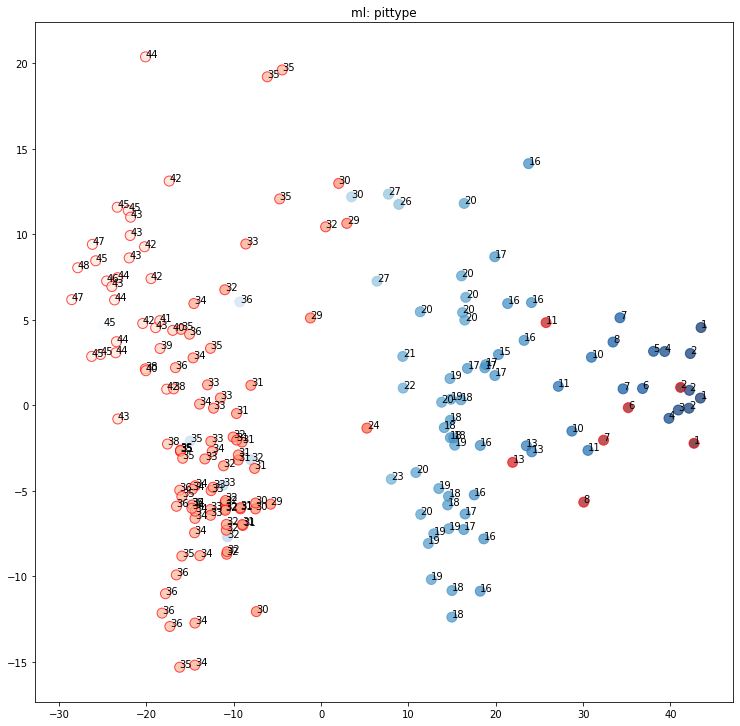

In [58]:
visualize(test_x, 'pittype')

In [79]:
reduced_data = dim_reduction(test_x)
kmeans = clustering(reduced_data)

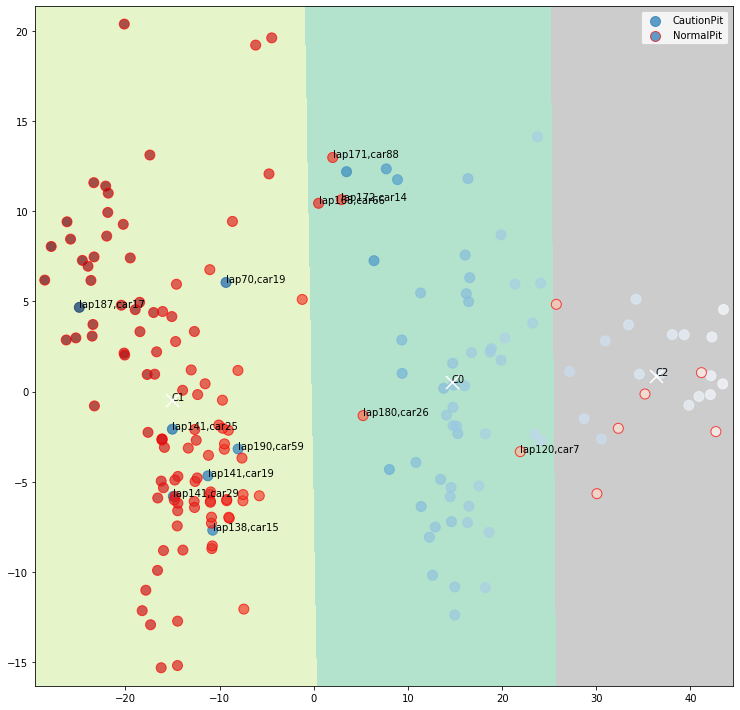

In [88]:
visualize(reduced_data, kmeans)

In [38]:
test_x.shape

(189, 7)

In [39]:
len(test_df)

189

In [31]:
test_df

,start_lap,pit_in_caution,eventid,car_number,stageid,firststage,start_position,start_rank,start_rank_ratio,top_pack,...,laps_prev,laps_after_last_pitstop,pittime_prev,prev_nb0_change_in_rank,prev_nb1_change_in_rank,prev_nb2_change_in_rank,follow_nb0_change_in_rank,follow_nb1_change_in_rank,follow_nb2_change_in_rank,cautionlaps_all
MyIdx,,,,,,,,,,,,,,,,,,,,,
1117,32,0,5,1,1,1,4,3,0.090909,1,...,32,32,66.06825,0,0,0,1,0,-3,32
1118,50,1,5,1,2,1,4,3,0.090909,1,...,18,18,61.12735,-9,-7,0,-5,-6,2,16
1119,70,1,5,1,3,1,4,9,0.272727,0,...,20,20,119.20330,3,6,-1,3,3,4,8
1120,101,0,5,1,4,1,4,9,0.272727,0,...,31,31,117.22760,4,5,-5,0,-2,-3,28
1121,135,0,5,1,5,1,4,8,0.242424,0,...,34,34,59.83245,-6,-5,-7,0,-1,-7,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,32,0,5,98,1,1,12,7,0.212121,0,...,32,32,63.28770,-3,0,1,0,0,0,32
1302,50,1,5,98,2,1,12,10,0.303030,0,...,18,18,61.57250,3,3,6,-5,-7,-8,15
1303,92,0,5,98,3,1,12,15,0.454545,0,...,42,42,116.28375,7,2,3,6,6,5,27


In [33]:
testset = test_df.to_numpy()
np.where(testset[:,1]==1)

(array([  1,   2,   7,  11,  16,  17,  21,  23,  24,  29,  31,  33,  36,
         38,  40,  45,  47,  51,  54,  55,  57,  60,  61,  64,  65,  66,
         67,  69,  73,  75,  76,  79,  84,  89,  90,  92,  97, 100, 101,
        102, 105, 109, 110, 112, 113, 116, 117, 118, 121, 122, 124, 126,
        131, 136, 137, 139, 144, 145, 149, 150, 151, 154, 155, 156, 159,
        162, 165, 168, 171, 172, 177, 178, 181, 183, 185]),)

In [44]:
lap_prev = test_df.laps_prev.values
print(np.min(lap_prev), np.max(lap_prev))

1 48
